# Imports

In [1]:
import numpy as np                     
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt       
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import braingeneers                  
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
from multiprocessing import Pool
from tqdm import tqdm

# Data

In [2]:
sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_47801/653605344.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


# Code

In [3]:
def calculate_mean_firing_rates(spike_data):
    # Compute mean firing rates for each neuron
    firing_rates = [len(train) / spike_data.length for train in spike_data.train]
    return firing_rates

def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

In [4]:
def create_histograms_for_events(spike_data, event_ranks, spatial_range=(82, 1092), time_window_rank=30, bins=6):
    total_events = len(event_ranks)

    histograms_for_each_event = {}

    distances = precalculate_distances_angles(get_neuron_positions(spike_data))[0]
    angles = precalculate_distances_angles(get_neuron_positions(spike_data))[1]

    # distance_bins = np.linspace(0, np.max(distances), bins+1)
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)
    # angle_bins[-1] += 1e-10  # Make sure the last bin edge is included

    print_every_n = max(total_events // 100, 1)  # Update progress every 10% or at least once
    
    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id + 1}/{total_events}...")
            
        start_rank = max(0, current_event_id - time_window_rank)
        end_rank = min(total_events, current_event_id + time_window_rank + 1)

        event_distances, event_angles = [], []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue

            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if spatial_range[0] < distance < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)

        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_for_each_event[current_event_id] = {
            'distance': distance_hist,
            'angle': angle_hist
        }
    
    print("Processing complete")
    return histograms_for_each_event

In [17]:
def apply_sliding_window_average(spike_data, event_histograms, window_width=17.5, bins=6):
    smoothed_histograms = {}
    total_events = len(event_histograms)
    time_window_rank = 30
    distances = precalculate_distances_angles(get_neuron_positions(spike_data))[0]
    angles = precalculate_distances_angles(get_neuron_positions(spike_data))[1]
    event_ranks = calculate_event_ranks(spike_data)
    close_neurons = precompute_close_neurons(precalculate_distances_angles(get_neuron_positions(spike_data))[0], window_size=window_width)
    print_every_n = max(len(event_ranks) // 100, 1)  # Update progress every 10% or at least once

    count = 0

    for current_event_id, histograms in event_histograms.items():
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id + 1}/{len(event_histograms)}...")

        # current_neuron_id = event_ranks[event_id][0]

        # Initialize summed histogram for the current event
        summed_histogram = {'distance': np.zeros(bins), 'angle': np.zeros(bins)}
        summed_histogram_count = 1

        # Add the histograms of the current event to the sum
        summed_histogram['distance'] += histograms['distance']
        summed_histogram['angle'] += histograms['angle']

        start_rank = max(0, current_event_id - time_window_rank)
        end_rank = min(total_events, current_event_id + time_window_rank + 1)

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if distance < window_width:
                summed_histogram['distance'] += event_histograms[other_event_id]['distance']
                summed_histogram['angle'] += event_histograms[other_event_id]['angle']
                summed_histogram_count += 1

        if summed_histogram_count > 0:
            smoothed_histograms[current_event_id] = {
                'distance': np.round(summed_histogram['distance'] / summed_histogram_count, 3),
                'angle': np.round(summed_histogram['angle'] / summed_histogram_count, 3)
            }

    return smoothed_histograms

In [18]:
histograms = create_histograms_for_events(sd, calculate_event_ranks(sd), spatial_range=(82, 1092), time_window_rank=30, bins=6)
smoothed_histograms = apply_sliding_window_average(sd, histograms, window_width=17.5, bins=6)

Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...
Processing event 2269/113477...


/tmp/ipykernel_47801/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/113477...
Processing event 34021/113477...
Processing event 35155/113477...
Processing event 36289/113477...
Processing event

In [19]:
def subtract_average_histograms(spike_data, averaged_histograms, window=336, bins=6):
    final_histograms = {}
    window_histograms = apply_sliding_window_average(spike_data, averaged_histograms, window_width=window, bins=bins)

    final_histograms = {event_id: {
        'distance': np.maximum(0, np.round(averaged_histograms[event_id]['distance'] - window_histograms[event_id]['distance'], 3)),
        'angle': np.maximum(0, np.round(averaged_histograms[event_id]['angle'] - window_histograms[event_id]['angle'], 4))
    } for event_id in averaged_histograms}

    return final_histograms

In [20]:
final_histograms = subtract_average_histograms(sd, smoothed_histograms, window=336, bins=6)

/tmp/ipykernel_47801/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...
Processing event 2269/113477...
Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/1134

In [21]:
final_histograms

{0: {'distance': array([0.   , 0.   , 0.278, 0.   , 0.   , 0.   ]),
  'angle': array([1.5, 0. , 0. , 0. , 0. , 0. ])},
 1: {'distance': array([0.   , 0.   , 0.   , 0.   , 1.417, 0.   ]),
  'angle': array([0., 0., 0., 0., 0., 0.])},
 2: {'distance': array([1.143, 0.   , 0.   , 0.   , 0.393, 0.   ]),
  'angle': array([0.   , 0.   , 0.   , 1.464, 0.   , 0.   ])},
 3: {'distance': array([0.   , 0.   , 2.083, 0.   , 3.958, 0.   ]),
  'angle': array([1.667, 2.75 , 0.   , 0.   , 0.   , 0.   ])},
 4: {'distance': array([0., 0., 0., 0., 0., 0.]),
  'angle': array([0. , 0. , 0. , 1.2, 0. , 0. ])},
 5: {'distance': array([0.971, 0.   , 0.   , 0.   , 0.   , 1.559]),
  'angle': array([0.   , 0.   , 0.   , 0.   , 0.   , 1.824])},
 6: {'distance': array([0.   , 0.   , 0.   , 0.   , 2.222, 0.   ]),
  'angle': array([0.   , 0.   , 3.444, 0.   , 0.   , 0.   ])},
 7: {'distance': array([0.   , 0.654, 0.   , 0.769, 0.   , 0.   ]),
  'angle': array([0.   , 0.   , 0.654, 2.154, 1.154, 0.   ])},
 8: {'distan

In [22]:
def compute_average_angle_from_histogram(angle_hist):
    # Check if the histogram data is valid
    if len(angle_hist) != 6:
        raise ValueError("The histogram must have 6 bins.")

    # Bin midpoints in degrees
    angle_midpoints_degrees = np.array([30, 90, 150, 210, 270, 330])
    # Convert midpoints to radians for calculations
    angle_midpoints_radians = np.radians(angle_midpoints_degrees)

    # Calculate the vector components of each bin's contribution
    x_components = angle_hist * np.cos(angle_midpoints_radians)
    y_components = angle_hist * np.sin(angle_midpoints_radians)

    # Compute the mean vector components
    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians

def compute_average_distance_angle(final_histograms, bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        # normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

In [28]:
def compute_average_angle_from_histogram(angle_hist):
    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians

def compute_average_distance_angle(final_histograms, bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        # normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

def calculate_stats_per_neuron(spike_data, histograms):
    distances_angles_per_neuron = {}
    event_ranks = calculate_event_ranks(spike_data)
    avg_dist_angles = compute_average_distance_angle(histograms, bins=6)

    for event_id in avg_dist_angles:
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in distances_angles_per_neuron:
            distances_angles_per_neuron[neuron_id] = []
        distances_angles_per_neuron[neuron_id].append(avg_dist_angles[event_id])
    
    return distances_angles_per_neuron

In [37]:
# histograms = create_histograms_for_events(sd, calculate_event_ranks(sd), spatial_range=(82, 1092), time_window_rank=30, bins=6)
# averaged_histograms_17 = apply_sliding_window_average(sd, histograms, window_width=17.5, bins=6)
# averaged_histograms_336 = apply_sliding_window_average(sd, histograms, window_width=336, bins=6)
# # final_histograms = subtract_average_histograms(sd, averaged_histograms, window=336, bins=6)

Total unique events: 113477
Processing event 1/113477...


/tmp/ipykernel_510/2426340036.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 1135/113477...
Processing event 2269/113477...
Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/113477...
Processing event 34021/113477...
Processing event 3

In [25]:
avg_dist_angles = compute_average_distance_angle(final_histograms, bins=6)

[ 30.  90. 150. 210. 270. 330.]


/tmp/ipykernel_47801/711047810.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_47801/711047810.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [29]:
distances_angles_per_neuron = calculate_stats_per_neuron(sd, final_histograms)

Total unique events: 113477
[ 30.  90. 150. 210. 270. 330.]


/tmp/ipykernel_47801/244665823.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_47801/244665823.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [30]:
def averages_per_postion(distances_angles_per_neuron):
    avg_distances_angles = {}
    neuron_positions = get_neuron_positions(sd)
    for neuron_id, stats in distances_angles_per_neuron.items():
        avg_distance = np.mean([stat['distance'] for stat in stats])
        avg_angle = np.mean([stat['angle'] for stat in stats])
        avg_distances_angles[neuron_id] = {'distance': avg_distance, 'angle': avg_angle, 'position': neuron_positions[neuron_id]}
    return avg_distances_angles

In [31]:
results = averages_per_postion(distances_angles_per_neuron)

/tmp/ipykernel_47801/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


In [33]:
results

{124: {'distance': 699.629635546041,
  'angle': nan,
  'position': array([1470. , 1382.5])},
 89: {'distance': 526.4626348158905,
  'angle': nan,
  'position': array([1417.5,  577.5])},
 1: {'distance': 390.4948272802454,
  'angle': 3.342527365073559,
  'position': array([1155., 1295.])},
 134: {'distance': 620.6776690481383,
  'angle': 1.8990838409107647,
  'position': array([1295. , 1452.5])},
 66: {'distance': 668.248845864895,
  'angle': nan,
  'position': array([1102.5,  157.5])},
 68: {'distance': 508.1058412952648,
  'angle': 2.0527681982362505,
  'position': array([1260., 1155.])},
 41: {'distance': 634.515506062354,
  'angle': nan,
  'position': array([ 910., 1435.])},
 3: {'distance': 448.0449707139252,
  'angle': 3.673470795462668,
  'position': array([1015. , 1277.5])},
 29: {'distance': 518.5236841753712,
  'angle': 3.7122696324067608,
  'position': array([1155.,  945.])},
 34: {'distance': 684.1736837360124,
  'angle': 2.5180714486424836,
  'position': array([1487.5,  682

In [42]:
def plot_data(data):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] / 8  # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    plt.show()


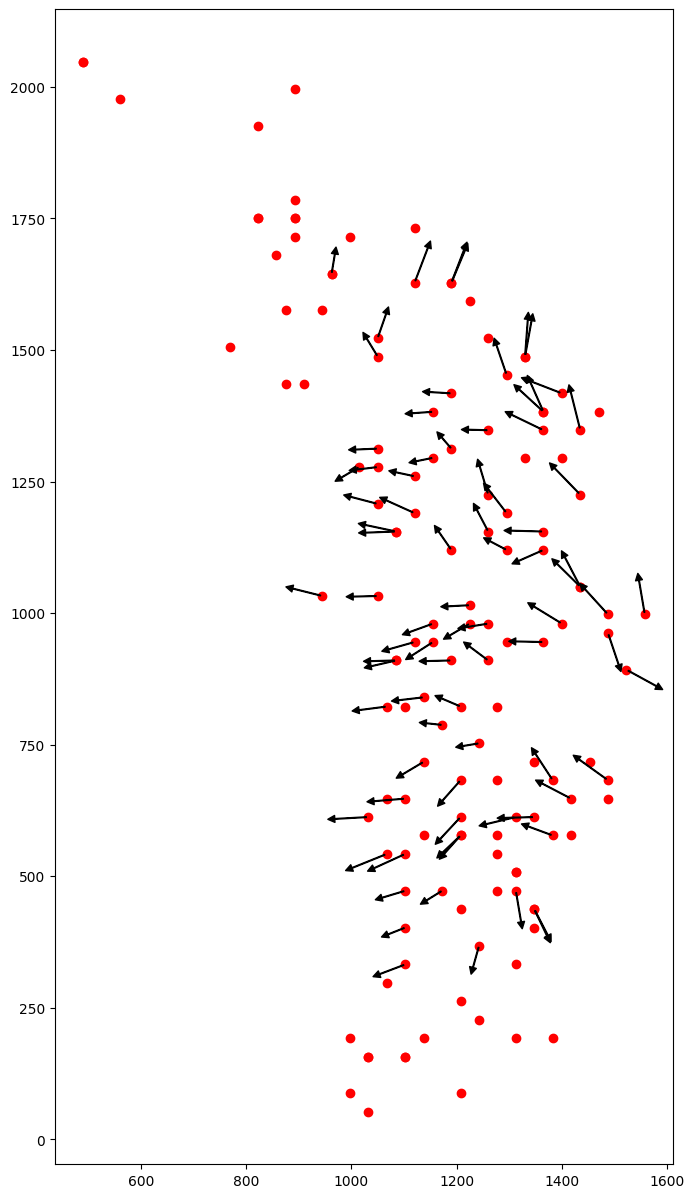

In [43]:
plot_data(data=results)

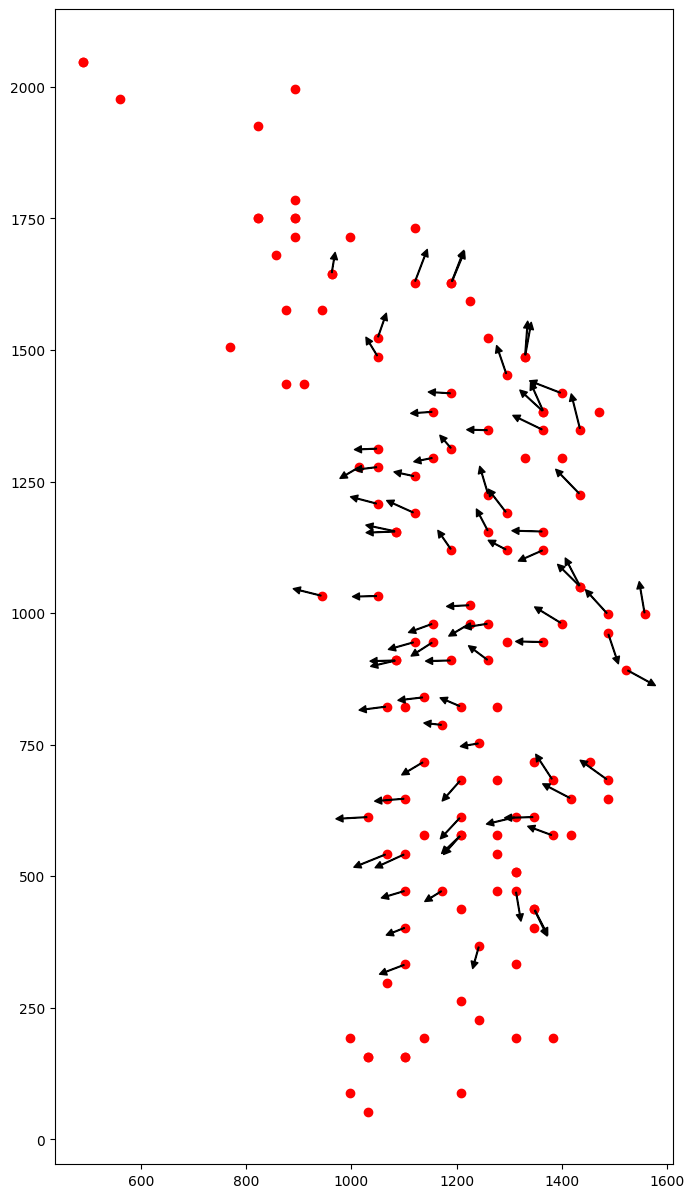

In [32]:
data = results

# Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size
for key, value in data.items():
    position = value['position']
    angle = value['angle']
    distance = value['distance'] / 10  # Scaling down the distance for better visualization on the plot
    
    # Calculate the end point of the arrow
    end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
    
    # Plotting the point in red
    ax.plot(position[0], position[1], 'o', color='red')
    
    # Plotting the arrow with narrower and less bold appearance
    ax.annotate('', xy=end_point, xytext=position, arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
    
ax.set_aspect('equal')
plt.show()

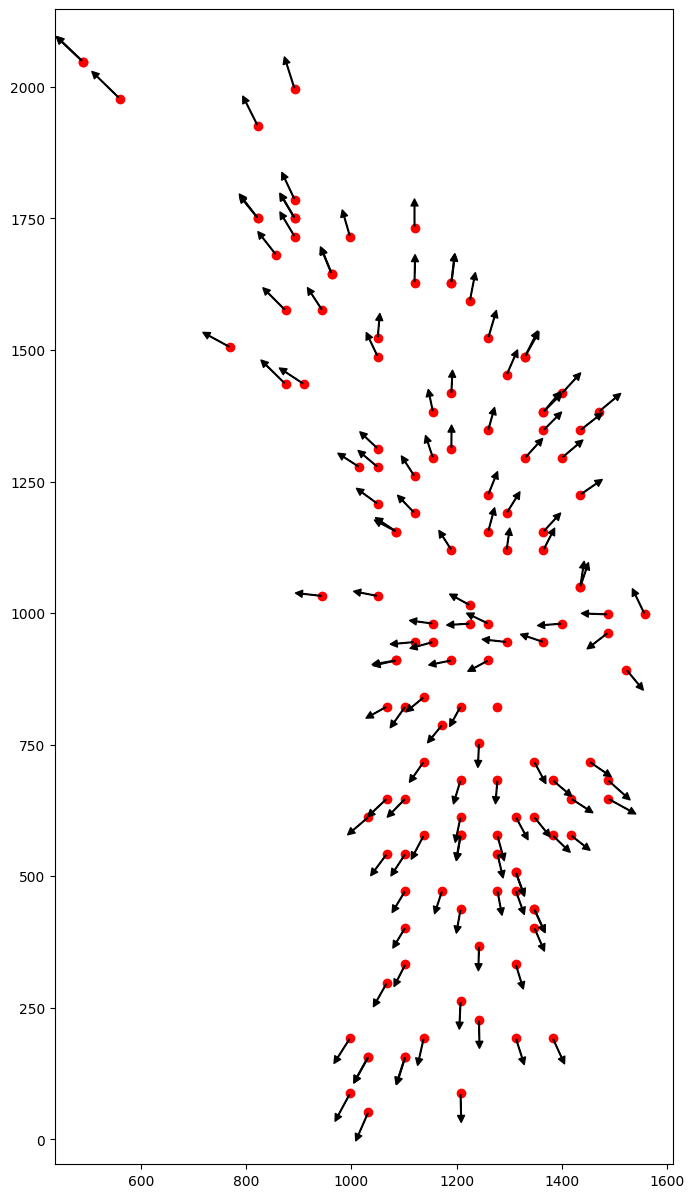

In [82]:
data = results_basic

# Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size
for key, value in data.items():
    position = value['position']
    angle = value['angle']
    distance = value['distance'] / 10  # Scaling down the distance for better visualization on the plot
    
    # Calculate the end point of the arrow
    end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
    
    # Plotting the point in red
    ax.plot(position[0], position[1], 'o', color='red')
    
    # Plotting the arrow with narrower and less bold appearance
    ax.annotate('', xy=end_point, xytext=position, arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
    
ax.set_aspect('equal')
plt.show()

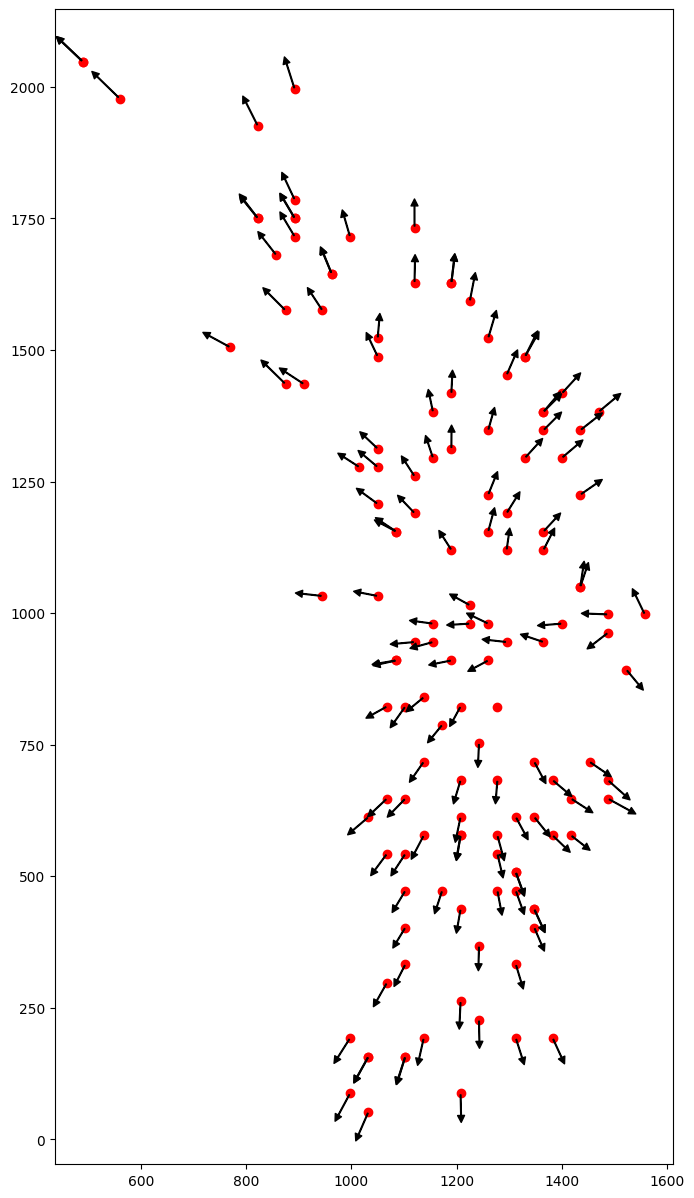

In [75]:
data = results

# Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size
for key, value in data.items():
    position = value['position']
    angle = value['angle']
    distance = value['distance'] / 10  # Scaling down the distance for better visualization on the plot
    
    # Calculate the end point of the arrow
    end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
    
    # Plotting the point in red
    ax.plot(position[0], position[1], 'o', color='red')
    
    # Plotting the arrow with narrower and less bold appearance
    ax.annotate('', xy=end_point, xytext=position, arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
    
ax.set_aspect('equal')
plt.show()

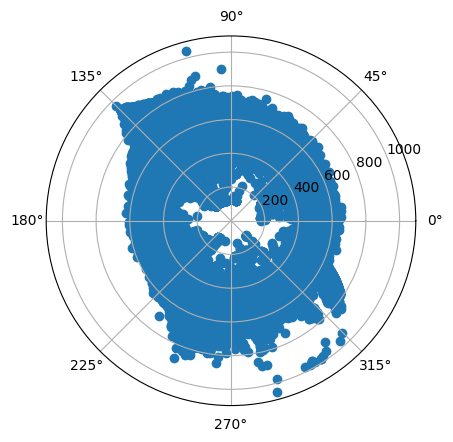

In [38]:
results = avg_dist_angles
# Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

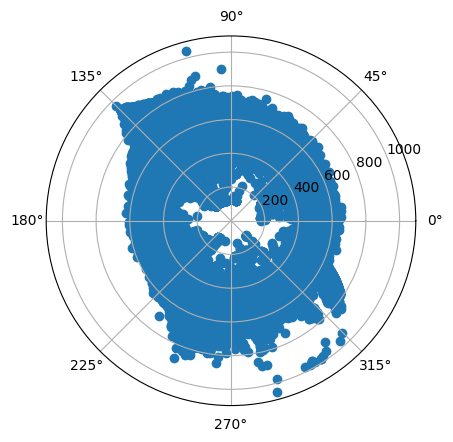

In [32]:
results = avg_dist_angles
# Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

In [25]:
total_non_whole = 0

# Iterate over the dictionary
for key, value in averaged_histograms.items():
    # Iterate over distance and angle arrays
    for array_name, array in value.items():
        num_not_whole = sum(1 for num in array if num < 0)
        total_non_whole += num_not_whole

print(f"Total number of elements across all arrays and entries that are not whole numbers or do not end in 0.5: {total_non_whole}")

Total number of elements across all arrays and entries that are not whole numbers or do not end in 0.5: 0
